Marcin Wardyński  
czwartek, 8:00

## Odpowiadanie na pytania na podstawie reprezentacji wektorowej dokumentów

#### Przygotowanie funkcji pomocniczych

Rozpoczynam od przygotowania funkcji pomocniczych, które umożliwią mi wykonanie ćwiczenia:
- `neural_utils.py` zawiera funkcje używane w poprzednich ćwiczeniach do:
    - pobrania i przetworzenia zbioru FIQA-PL
    - obliczenia NDCG
- poniższe bloki kodu zawierają funkce:
    - `load_docs_into_data_store` do załadowania danych do wektorowej bazy danych
    - `build_query_pipeline` buduje pipeline potrzebny do zapytań do wektorowej bazy danych
    - `query_data_store` przeprowadza zapytanie

Do przechowywania pasaży w postaci wektorowej wykorzystuje `Qdrant`, a model neuronowy przekazuję do funkcji zarówno podczas eksportu danych, jak i stawiania pytania, gdyż pasaże oraz pytania muszą zostać przekształcone do embeddingów wektorowych.

In [10]:
import neural_utils as utils

corpus, queries, qrels = utils.load_fiqa()
all_docs = corpus['corpus']

test_query_to_corpus_dict = utils.prepare_fiqa_qrels(qrels, ['test'])
test_queries_dict = utils.prepare_fiqa_queries_for_selected_subset(queries, test_query_to_corpus_dict)

In [2]:
from haystack.document_stores.types import DuplicatePolicy
from haystack import Document
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

from haystack_integrations.document_stores.qdrant import QdrantDocumentStore


def load_docs_into_data_store(document_store, all_docs, model):
    documents = [Document(id=doc['_id'], content=doc['text']) for doc in all_docs]
    
    document_embedder = SentenceTransformersDocumentEmbedder(model=model)  
    document_embedder.warm_up()
    documents_with_embeddings = document_embedder.run(documents)

    document_store.write_documents(documents_with_embeddings.get("documents"), policy=DuplicatePolicy.OVERWRITE)

In [3]:
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever

from haystack.components.classifiers import TransformersZeroShotDocumentClassifier

def build_query_pipeline(document_store, model, top_k):
    retriever = QdrantEmbeddingRetriever(document_store=document_store, top_k=top_k)

    query_pipeline = Pipeline()
    query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model=model))
    query_pipeline.add_component("retriever", retriever)
    query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")

    return query_pipeline

def query_data_store(query_pipeline, query, n):
    result = query_pipeline.run({"text_embedder": {"text": query}})
    return result['retriever']['documents'][:n]


#### Zapytania przy użyciu modelu `Roberta-Base`

Inicjalizuję *document store* w pamięci i ładuję do niego pasaże:

In [10]:

model = "sdadas/mmlw-retrieval-roberta-base"

document_store = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
)

load_docs_into_data_store(document_store, all_docs, model)

Batches: 100%|██████████| 1802/1802 [30:58<00:00,  1.03s/it]
57700it [01:11, 806.30it/s]                           


Jak w laboratorium 2 i 5 wykorzystuję pytania ze zbioru testowego do obliczenia NDCG@5:

In [49]:
model = "sdadas/mmlw-retrieval-roberta-base"

top_k = 5
query_pipeline = build_query_pipeline(document_store, model, top_k)

ndcgs_size = 5
ndcgs = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline, query_data_store, ndcgs_size)

Batches: 100%|██████████| 1/1 [00:00<00:00, 48.28it/s]


Wizualizacja otrzymanych wyników:

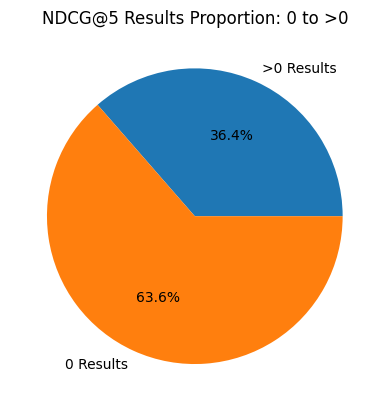

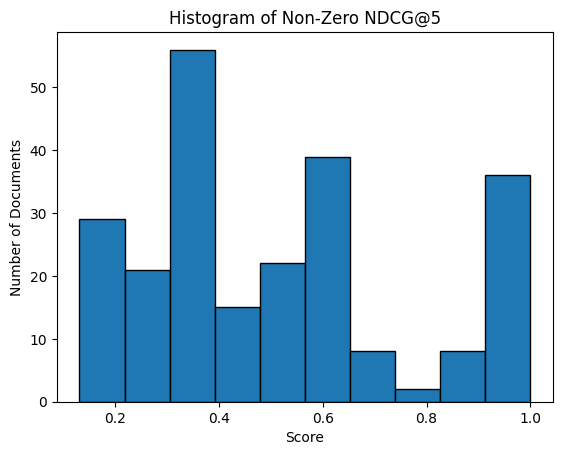

NDCG@5 Mean: 0.18988865853627918 and Std: 0.29692386698863327
NDCG@5 > 0 Mean: 0.5213891980148683 and Std: 0.2631273967008143


In [51]:
utils.present_results(ndcgs)

Używając transformera `Roberta-Base` dla wyliczania embeddingów wektorowych 36,4% zapytań otrzymało odpowiedzi z NDCG@5 większym od zera, a wśród nich średnia wartość NDCG@5 wynosi 0.52.

#### Zapytania przy użyciu modelu `E5-Base`

Postępuję identycznie, jak w poprzednim podpunkcie, tylko zmieniam używany transformer na `E5-Base`, dla którego to tworzę nowy *document store*

In [6]:
model = "sdadas/mmlw-retrieval-e5-base"

document_store_e5 = QdrantDocumentStore(
    ":memory:",
    recreate_index=True,
    return_embedding=True,
    wait_result_from_api=True,
    similarity="cosine",
    embedding_dim=768
)

load_docs_into_data_store(document_store_e5, all_docs, model)

Batches: 100%|██████████| 1802/1802 [35:43<00:00,  1.19s/it] 
57700it [01:13, 785.04it/s]                           


In [15]:
model = "sdadas/mmlw-retrieval-e5-base"

top_k = 5
query_pipeline_e5 = build_query_pipeline(document_store_e5, model, top_k)

ndcgs_size = 5
ndcgs_e5 = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline_e5, query_data_store, ndcgs_size)

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]


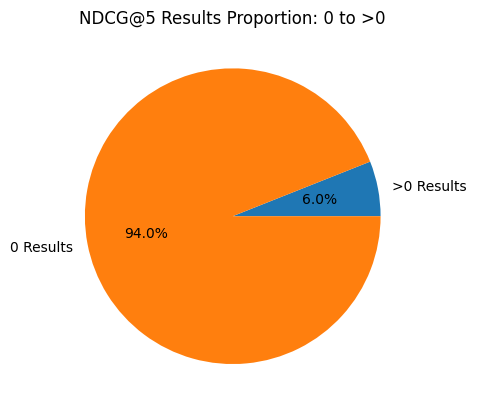

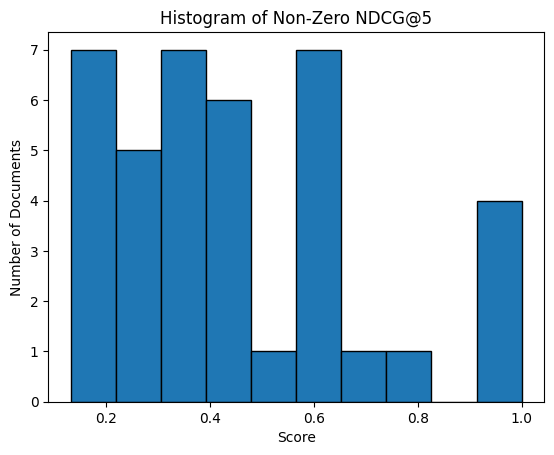

NDCG@5 Mean: 0.028071690803648006 and Std: 0.1264337357809436
NDCG@5 > 0 Mean: 0.46642193950676686 and Std: 0.24728300355564733


In [16]:
utils.present_results(ndcgs_e5)

Uzyskane wyniki są bardzo kiepskie, gdyż tylko 6% zpytań ma niezerowe NDCG@5. Przyczyną tak kiepskiego wyniku może być niewłaściwa konfiguracja obiektu `QdrantEmbeddingRetriever`, który to jest *Dense Retrievererm* dla *document store* `Qdrant` w `Haystack 2.0` i wyżej.

Instrukcja ćwiczenia odsyłała do dyskusji na githubie w związku z właściwą konfiguracją, jednakże przykład tam zamieszczony używa `Haystack 1.X` i jest trudny do odwzorowania w nowej wersji `Haystack`.

#### Zapytania przy użyciu modelu `Roberta-Base` z dodatkowym klasyfikatorem

Jako klasyfikator wykorzystuję transformer `herbert-base`, który w ramach laboratorium 5 został poddanych fine-tuningowi, aby lepiej klasyfikował dostarczane mu pary pytanie, odpowiedź. Użyję najlepszego modelu z lab 5, czyli: `best_model_f1_rand`. Dla przypomnienia: przy treningu korygowany był na podstawie metryki *f1-score*, a uczył się bazując na losowych parach pytanie-pasaż, gdzie pasaże z negatywnych dopasowań należą do TOP50 pasaży zwróconych z FTS. Po więcej szczegółów odsyłam do sprawozdana z lab 5.

W pierwszej kolejności dopasowuję nazwy etykiet pozytywnych i negatywnych, żeby odpowiadały tym oczekiwanym przez `Haystack`:

In [7]:
from transformers import AutoModelForSequenceClassification

class_model = "./best_model_f1_rand"

model = AutoModelForSequenceClassification.from_pretrained(class_model)

model.config.label2id = {"contradiction": 0, "entailment": 1}
model.config.id2label = {0: "contradiction", 1: "entailment"}
model.save_pretrained(class_model)

Następnie tworzę komponent używany do łączenia pytania z pasażem zwróconym z *document store*. gdyż właśnie takiej reprezentacji oczekuje nasz model `best_model_f1_rand` użyty do klasyfikacji:

In [8]:
from typing import List
from haystack import component

@component
class QACombiner:

    @component.output_types(documents=List[Document])
    def run(self, query:str, documents:List[Document]):
        separator = "</s>"

        documents_out = [Document(id = document.id, content = f"{query}{separator}{document.content}") for document in documents]

        return {"documents": documents_out}

Definiuję na nowo pipeline do stawiania zapytań, tym razem uwzględniając klasyfikator, oraz funkcję wyszukującą odpowiedzi, która dodatkowo przeprowadza reranking na podstawie sugestii klasfikatora:

In [9]:
def build_query_pipeline_with_classification(document_store, ret_model, class_model, top_k):
    retriever = QdrantEmbeddingRetriever(document_store=document_store, top_k=top_k)
    classifier = TransformersZeroShotDocumentClassifier(model=class_model, labels=["contradiction", "entailment"])
    classifier.warm_up()
    qa_combiner = QACombiner()

    query_pipeline = Pipeline()
    query_pipeline.add_component("text_embedder", SentenceTransformersTextEmbedder(model=ret_model))
    query_pipeline.add_component("retriever", retriever)
    query_pipeline.add_component("qa_combiner", qa_combiner)
    query_pipeline.add_component("classifier", classifier)
    query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
    query_pipeline.connect("retriever.documents", "qa_combiner.documents")
    query_pipeline.connect("qa_combiner", "classifier")

    return query_pipeline

def qeury_data_store_with_classifier(query_pipeline, query, n):
    result = query_pipeline.run({"qa_combiner": {"query": query}, "text_embedder": {"text": query}})

    documents = result['classifier']['documents']
    reranked_documents = sorted(documents, key=lambda doc: doc.meta['classification']['details']["entailment"], reverse=True)

    return reranked_documents[:n]

Wywołanie nowych metod nie różni się właściwie niczym, od ich poprzednich definicji:

In [ ]:
model = "sdadas/mmlw-retrieval-roberta-base"
class_model = "./best_model_f1_rand"

top_k = 10
query_pipeline_comb = build_query_pipeline_with_classification(document_store, model, class_model, top_k)

ndcgs_size = 5
ndcgs_class = utils.calculate_ndcgs(test_queries_dict, test_query_to_corpus_dict, query_pipeline_comb, qeury_data_store_with_classifier, ndcgs_size)

Zanim przejdziemy do wyników zobaczmy jak wygląda pipeline, gdyż tym razem jest dużo ciekawszy, niż w bazowej wersji ćwiczenia.

Na poniższym diagramie widzimy, że odpowiedzi uzyskane przez *dense retriever* przekazywane są wraz z zapytaniem początkowym do komponentu `qa_combiner`, który przygotowuje zapytanie zgodne ze standardem oczekiwanym przez model klasyfikujący:

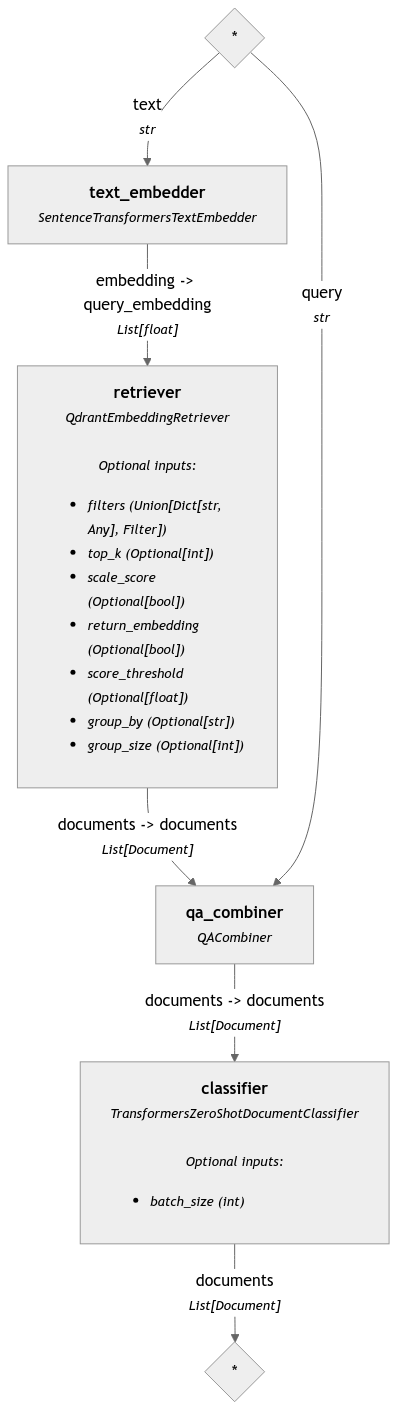

In [14]:
query_pipeline_comb.show()

Przetwarzanie takim pipeline-m trwa prawie 20x dłużej, niż wersją standardową bez użycia klasyfikatora.

Pora na wyniki:

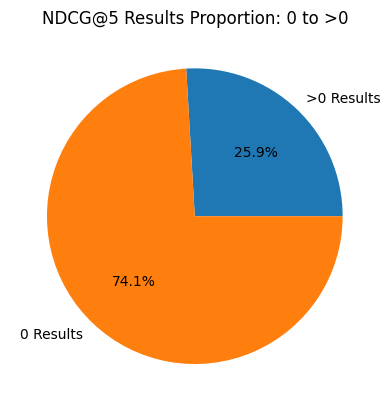

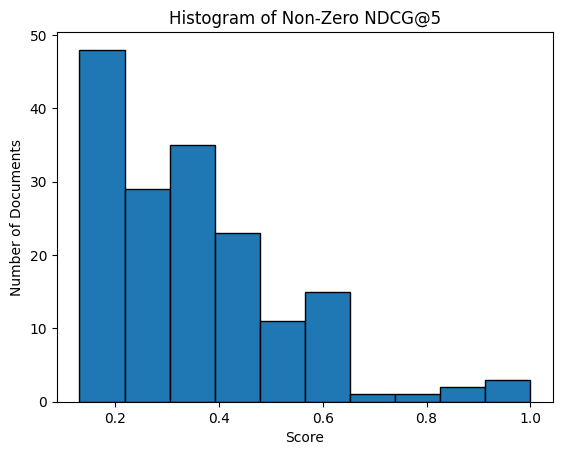

NDCG@5 Mean: 0.09148283798166816 and Std: 0.17920414000477347
NDCG@5 > 0 Mean: 0.3528623750721486 and Std: 0.17787006199949212


In [61]:
# ["contradiction", "entailment"]

utils.present_results(ndcgs_class)

Niestety wprowadznie klasyfikatora pogorszyło jakość zwracanych wyników, obniżając liczbę zapytań z niezerowym NDCG@5 do 25.9%, wśród których średnia wartość NDCG@5 wynosi 0.35. Ewidentnie dodatkowy reranking wprowadzony przez klasyfikator tylko pogorsza wyniki całego pipeline-u, co świadczy o tym, że model użyty do klasyfikacji niekoniecznie dobrze odwzorowuje oczekiwane relacje pytanie-pasaż.

In [43]:
#code to reload the neural_utils file
import importlib
import neural_utils
importlib.reload(neural_utils)

<module 'neural_utils' from '/Users/mwardynski/Documents/ds/_semestr_9/przetwarzanie_jezyka_naturalnego/labs/lab8/neural_utils.py'>

### Pytania do ćwiczenia

#### Porównanie jakości wyników:

Porównując jakość wyników, wybieram najlepsze modele z każdego z laboratoriów:

|                                    | FTS   | Klasyfikacja | Reprezentacja wektorowa |
|------------------------------------|-------|--------------|-------------------------|
| NDCG@5 > 0                         | 34.4% | 39.2%        | 36.4%                   |
| Średni NDCG@5 (wykluczając zerowe) | 0.537 | 0.545        | 0.521                   |

Zdecydowanie najlepszą jakóść dopasowania odpowiedzi na pasaże daje metoda z laboratorium 5, polegająca na użyciu transformera w postaci rerankera, który ustawia odpowiedzi uzyskane od FTS w nowej kolejności. (Zastanawia słaby wynik rerankingu z użyciem tego samego modelu w tym zadaniu).

Drugie miejsce należy się wyszukiwaniu bazującemu na reprezentacji wektorowej, z liczbą niezerowych NDCG@5 większą o 2 punkty procentowe od bazowego FTS, lecz odrobinę mniejszą wartością NDCG@5 wśród tych wyników.

FTS wypadłw tym zestawieniu najsłabiej.

#### Porównanie szybkości działania:

Porównanie szybkości działania wykonałem dla tego samego zestawu, co w punkcie powyżej:

|                          | FTS              | Klasyfikacja                                 | Reprezentacja wektorowa |
|--------------------------|------------------|----------------------------------------------|-------------------------|
| Indeksowanie s/dokument  | 0.31s/dok        | Trening: 2.99s/dok + Indeksowanie: 0.31s/dok | 1.27s/dok               |
| Wyszykiwanie s/zapytanie | 0.019s/zapytanie | 0.95s/zapytanie                              | 0.32s/zapytanie         |

Widać, że zarówno indeksowanie, jak i wyszukiwanie przy pomocy FTS jest najszybsze, natomiast konwersja dokumentów do postaci wektorowej, oraz ich późniejsze przeszukiwanie w tej formie zajmuje więcej czasu. Najwięcej czasu pochłania fine-tuning modelu LLM do wybranego zadania oraz używanie modelu LLM do rerankingu wyników.

#### Porównaj pozostałe cechy:

|                                | Wyszukiwanie leksykalne                                                          | Wyszukiwanie wektorowe                                                                                     |
|--------------------------------|----------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------|
| Interpretowalność              | Bardzo wysoka - Zachodzące przekształcenia i dopasowanie łatwe w analizie        | Słaba - Postać wektorowa nie nadaje się do analizy przez człowieka                                         |
| Rozumienie semantyki/kontekstu | Brak - Każde słowo traktowane jest osobno                                        | Wysoka - Model potrafi nauczyć się relacji pomiędzy wyrazami                                               |
| Adaptowalność                  | Słaba - Mała liczba mechanizmów wspomagających użycie FTS w konkretnych domenach | Wysoka - Model przekształcający w embeddingi wektorowe może zostać doszkolony w zależności od zastosowania |
| Ilość danych                   | Duża - zwłaszcza gdy chcemy douczyć model tworzący embeddingi                    | Dowolna - działa równie dobrze dla małych, jak i dla dużych zbiorów dokumentów.                            |

#### Podsumowanie

Jak widać na podstawie powyższych tabel, wyszukiwanie leksykalne oraz wktorowe mają różną charakterystykę, przez co nadają się do różnych przypadków użycia.

Wyszukiwanie leksykalne nada się lepiej dla prostych wyszukiwań, bazujących na bezpośrednich trafieniach po małym preprocessingu, pomijających kontekst, ale za to nie wymagając dużego zbioru danych i zasobów obliczeniowych.

Z drugiej strony wyszukiwanie oparte na embeddingach wektorowych potrafi "zrozumieć" treść przeszukiwanych dokumentów i odnaleźć lepsze wyniki przy braku dokładnego dopasowania, lub też wyspecyfikowanych synonimów. W zamian za to, embeddingi wektorowe potrzebują więcej zasobów obliczeniowych oraz odpowiednio duży zbiór danych wejściowych, a sama wyszukiwanie jest wolniejsze.